In [5]:
import cuentitas
from cuentitas import a0VV, a1VVF1, a1VVF2
import auxiliaresGNSS as au

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import time

import pymc3 as pm
import random 
sns.set()

In [6]:
def patron(thi,ep1,ep2,d,s1,s2,ZA):
    
    landa = 0.19
    k0 = 2*np.pi/landa
    phi = 0
    ph = phi
    th = thi

    s0s = 1 + 2*np.real(a0VV(k0,thi,ep1,ep2,d)*exp(1j*2*k0*cos(th)*ZA))+abs(a0VV(k0,thi,ep1,ep2,d))**2\
        + abs(a1VVF1(k0,thi,phi,th,ph,ep1,ep2,d))**2*s1**2 + abs(a1VVF2(k0,thi,phi,th,ph,ep1,ep2,d))**2*s2**2
    
    s0s = 10*np.log10(s0s) #paso a db
    
    
    sM = TT.mean(s0s) #normalizo  #REVISAR 
    s0 = (s0s-sM)/TT.max(np.abs(s0s-sM)) #REVISAR

    nn = len(thi)
    
    a = TT.zeros(nn)

    for i in range(nn):
        a = TT.set_subtensor(a[i], s0[i])
        
    return a

In [7]:
def modelo(medidos,errores,samples,thi): 
    
    ranges = {}
    ranges['ep1'] = 4, 40
    ranges['ep2'] = 4, 40
    ranges['d'] = 0.03, 0.15
    ranges['s1'] = 0.005, 0.02
    ranges['s2'] = 0.005, 0.02
    ranges['Za'] = 3, 3.5

    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
        Za = pm.Uniform('Za', ranges['Za'][0], ranges['Za'][1])

    def f(ep1 = ep1,
          ep2 = ep2,
          d = d,
          s1 = s1,
          s2 = s2,
          Za = Za):
        return patron(thi,ep1,ep2,d,s1,s2,Za)
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=errores, observed=medidos)
        trace = pm.sample_smc(samples, parallel=True)
        
    return trace

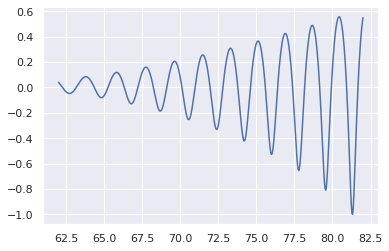

In [24]:
# Trabajo en angulos medidos desde el azimut, los angulos de elevacion (gps) estan medidos desde el suelo. VOY A LLAMAR ELEVACION A LOS MEDIDOS DESDE AZIMUT
# Las cotas que suponemos para nuestro suelo es entre 8º y 28º de elevacion y corresponden a ep entre 4 y 40. 

# inputs
epsilon1 = 6
epsilon2 = 10
de = 0.06
ssup = 0.007
sinf = 0.013
altura = 3.15

entrada = [epsilon1,epsilon2,de,ssup,sinf,altura]

# voy a analizar como varia al meter mas o menos mediciones, es decir, cambiando la discretizacion en los angulos
discretizacion = 500
elevacion = np.linspace(62*pi/180,82*pi/180, discretizacion)

s0 = au.generadorS0(elevacion,epsilon1,epsilon2,de,ssup,sinf,altura)
plt.plot(elevacion*180/pi,s0)

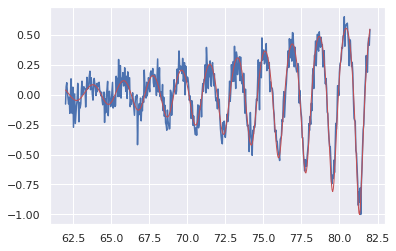

In [25]:
#agrego ruido
noise = 10 #Valor en porcentaje del ruido que quiero ej: 10 = 10% de ruido en la medicion

pert = au.generadorS0ruido(elevacion,epsilon1,epsilon2,de,ssup,sinf,altura,noise)
plt.plot(elevacion*180/pi,pert)
plt.plot(elevacion*180/pi,s0,linewidth=1,c='r')

In [26]:
t0 = time.time()

# medidos = s0
medidos = pert
sig = 0.15
errores = np.asarray(len(s0)*[sig])

muestreo = 10000

traza = modelo(medidos,errores,muestreo,elevacion)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As 

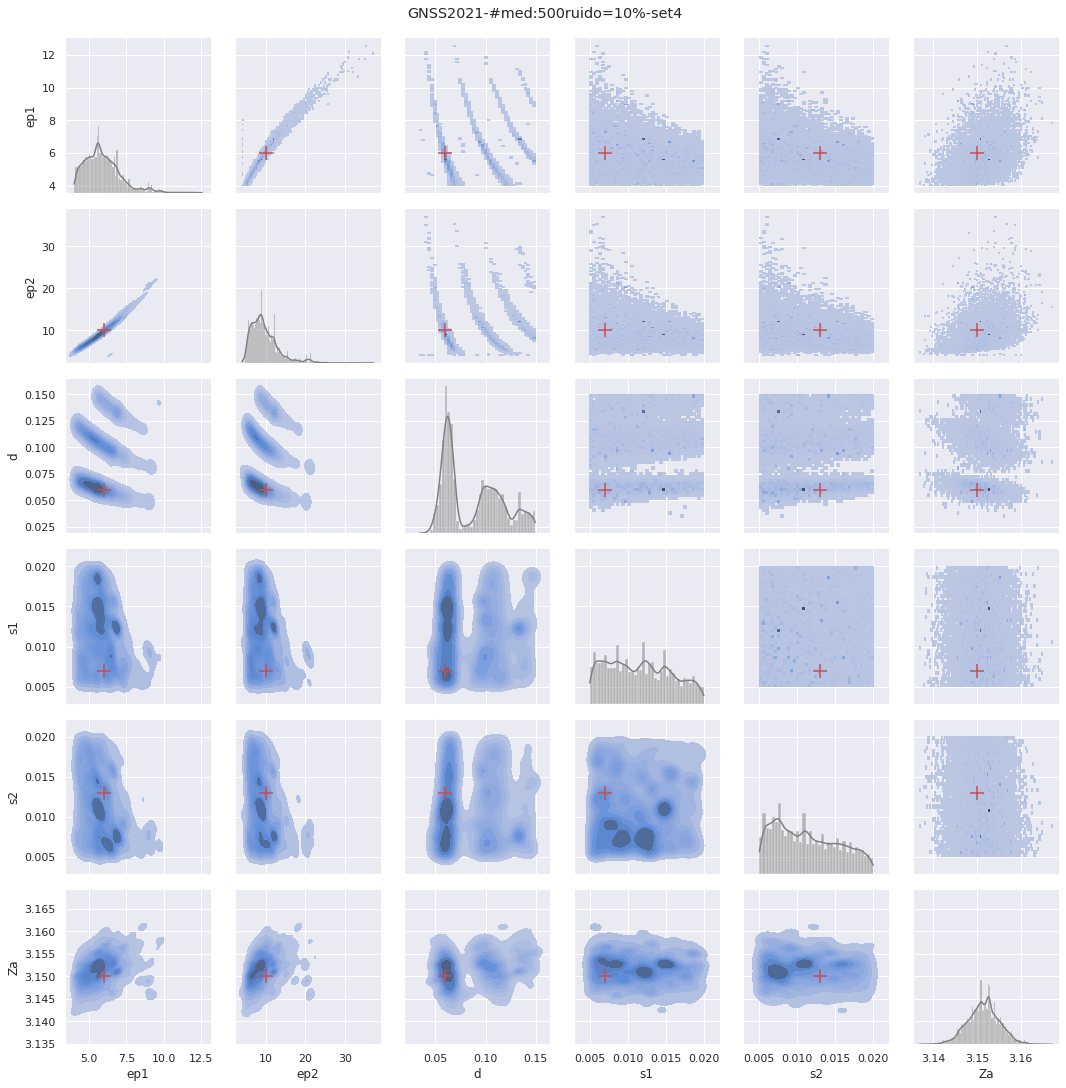

In [27]:
plotear = np.stack((traza['ep1'],traza['ep2'],traza['d'],traza['s1'],traza['s2'],traza['Za'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2','Za'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle('GNSS2021-#med:'+str(discretizacion)+'ruido='+str(noise)+'%-set4', y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')


for i in range(len(entrada)):
    for j in range(len(entrada)):
        if i == j:
            #ploteo el valor verdadero en las marginales
#             g.axes[j,i].axvline(entrada[i], color='r', linestyle='dashed', linewidth=1) #Este me descuajeringa todo, despues veo como arreglarlo
            pass
        else:
            g.axes[j,i].scatter(entrada[i], entrada[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)
            


In [28]:
Nombre = 'Analisis_de_error/#d='+str(discretizacion)+'m='+str(muestreo)+'sigma='+str(sig)+'-Ns='+str(noise)+'%-set4'
g.savefig(Nombre+'.png', dpi=300)

t1 = time.time()
print("Tiempo de ejecución:", t1-t0, 'seg','(', (t1-t0)/3600,  'hs )')

Tiempo de ejecución: 2282.772464990616 seg ( 0.6341034624973932 hs )


In [29]:
e1 = traza['ep1']
e2 = traza['ep2']
d = traza['d']
s1 = traza['s1']
s2 = traza['s2']
Za = traza['Za']

guardar = [e1,e2,d,s1,s2,Za]

f2 = np.savetxt(Nombre+'.txt',guardar, fmt='%s', delimiter=';')

In [ ]:
ep1 = 25
ep2 = 33
d = 0.1
s1 = 0.01
s2 = 0.015
z = 3.15

/home/jovyan/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


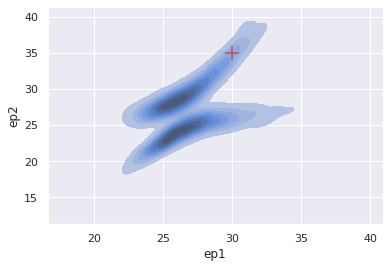

In [42]:
a = sns.kdeplot(traza['ep1'],traza['ep2'], fill=True)#, cmap='cubehelix',thresh = 0,levels=100)
a.set(xlabel='ep1', ylabel='ep2')
a.scatter(30, 35, marker="+", c='r', s=200)
fig = a.get_figure() 
# fig.savefig('Analisis_de_error/ep1ep2.png',dpi = 300)